# Credit Fraud Detector

## Introduction
This kernel will use and evaluate several predictive models to detect fraudulent transactions. The dataset, provided by Kaggle, has the features scaled and the names of the featres are not shown due to privacy reasons.

## Objectives:
    - Understand the distribution of the data that was provided
    - Implement isolation forest anomaly detection algorithm
    - Evaluate model and visualize results

In [56]:
# Import Libraries
import numpy as np #linear algebra
import pandas as pd #data pre-processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import datetime

#import scikit-learn models
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.neighbors import NearestNeighbors

#import scikit-learn metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

#import scikit-learn dataset and prep
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [2]:
# confusion matrix code
def plot_confusion_matrix(cm,title,classes=['abnormal','normal'],
                          cmap=plt.cm.Blues, save=False, saveas="ConfusionMatrix.png"):
    
    cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
    
    plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.1%'
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j],fmt),
                 horizontalalignment='center',
                color = 'white' if cm[i,j]>thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    if save:
        plt.savefig(saveas, dpi=300)

In [3]:
#import dataset
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
df.isnull().sum().max()

0

In [6]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
print('No Frauds',round(df['Class'].value_counts()[0]/len(df)*100,2),'% of the dataset')
print('Frauds',round(df['Class'].value_counts()[1]/len(df)*100,2),'% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: Not Fraud || 1: Fraud)')

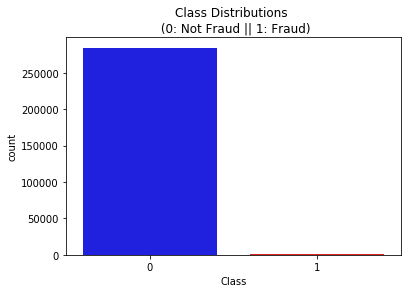

In [8]:
colours = ["blue","red"]
sns.countplot("Class",data=df,palette=colours)
plt.title('Class Distributions \n (0: Not Fraud || 1: Fraud)')

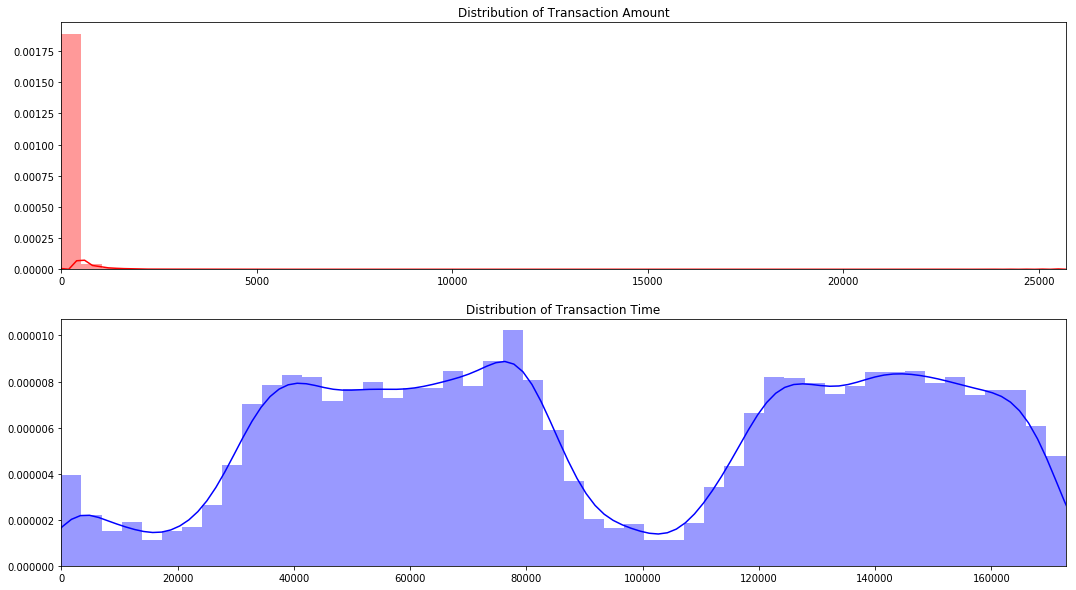

In [9]:
fig,ax = plt.subplots(2,1,figsize=(18,10))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val,ax=ax[0],color='r')
ax[0].set_title('Distribution of Transaction Amount',fontsize = 12)
ax[0].set_xlim([min(amount_val),max(amount_val)])

sns.distplot(time_val,ax=ax[1],color='b')
ax[1].set_title('Distribution of Transaction Time',fontsize = 12)
ax[1].set_xlim([min(time_val),max(time_val)])

plt.show()

In [18]:
ccIF = IsolationForest(max_samples=0.25, contamination=0.1,
                       n_estimators = 100, n_jobs = 1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Class'],axis=1),
                                                           df['Class'], test_size = 0.33)

In [27]:
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
56613,47504.0,0.789534,-0.512634,0.061550,1.358890,-0.202282,0.374317,0.131667,0.164126,0.188634,...,0.139150,0.027652,-0.186001,-0.264428,-0.306319,0.574555,-0.326017,-0.005822,0.032281,192.00
119299,75400.0,1.315404,-0.033577,-1.089984,-0.557087,2.029931,3.268130,-0.534994,0.808250,-0.052724,...,0.016952,-0.313307,-1.068934,0.103797,0.992126,0.369398,0.110374,-0.028302,0.011836,1.98
2556,2105.0,-0.643331,0.876486,1.114308,-2.067565,0.181702,-1.228307,1.117487,-0.333802,0.944917,...,0.140372,0.084476,0.735502,-0.218425,0.411130,0.019755,-0.826653,0.362879,0.047016,1.00
192079,129528.0,-0.991560,-0.781809,1.517014,-2.551986,-0.188730,-0.711116,-0.303494,-0.073738,-2.631623,...,-0.201336,-0.067833,0.099931,-0.281316,0.023249,0.616137,-0.057402,-0.133295,0.143048,25.00
48058,43475.0,0.977216,-1.525261,1.406270,-0.082650,-2.043912,0.267737,-1.344311,0.297746,0.612474,...,0.221761,0.213246,0.566248,-0.099751,0.447741,0.241376,-0.121030,0.057514,0.049334,150.00


In [20]:
start = datetime.datetime.now()
ccIF.fit(X_train)
y_pred_train = ccIF.predict(X_train)
end = datetime.datetime.now()
print(end-start)

C:\Users\vme\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\vme\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0:00:28.708235


In [26]:
start = datetime.datetime.now()
y_pred_train_lof = clfLOF.fit_predict(X_train_nd, y_train_nd)
end = datetime.datetime.now()
print (end-start)

NameError: name 'clfLOF' is not defined

In [21]:
print(y_pred_train)
for index,value in enumerate(y_pred_train):
    if value == -1:
        y_pred_train[index] = 1
    else:
        y_pred_train[index] = 0
print(y_pred_train)

[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]


              precision    recall  f1-score   support

     anomaly       1.00      0.90      0.95    190474
      normal       0.02      0.90      0.03       346

   micro avg       0.90      0.90      0.90    190820
   macro avg       0.51      0.90      0.49    190820
weighted avg       1.00      0.90      0.95    190820

AUC:  89.9%


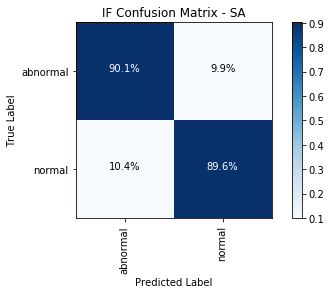

In [22]:
print(classification_report(y_train, y_pred_train, 
                            target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_train, y_pred_train)))
cm = confusion_matrix(y_train, y_pred_train)
plot_confusion_matrix(cm, title="IF Confusion Matrix - SA",
                      save=True, saveas="IF_CCTrian.png")

In [23]:
start = datetime.datetime.now()
y_pred_test = ccIF.predict(X_test)
end = datetime.datetime.now()
print(end-start)

C:\Users\vme\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0:00:05.166429


In [24]:
print(y_pred_test)
for index,value in enumerate(y_pred_test):
    if value == -1:
        y_pred_test[index] = 1
    else:
        y_pred_test[index] = 0
print(y_pred_test)

[ 1  1  1 ... -1  1  1]
[0 0 0 ... 1 0 0]


              precision    recall  f1-score   support

     anomaly       1.00      0.90      0.95     93841
      normal       0.01      0.88      0.03       146

   micro avg       0.90      0.90      0.90     93987
   macro avg       0.51      0.89      0.49     93987
weighted avg       1.00      0.90      0.95     93987

AUC:  89.3%


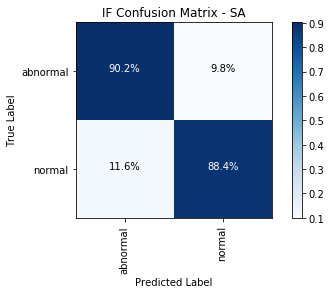

In [25]:
print(classification_report(y_test, y_pred_test, 
                            target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_pred_test)))
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm, title="IF Confusion Matrix - SA",
                      save=True, saveas="IF_CCTest.png")

In [28]:
df_no_labels = df.drop(['Class'],axis=1)
df_no_labels.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [33]:
start = datetime.datetime.now()
y_pred = ccIF.predict(df_no_labels)
end = datetime.datetime.now()
print(end-start)

C:\Users\vme\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0:00:17.663720


In [34]:
print(y_pred)
for index,value in enumerate(y_pred):
    if value == -1:
        y_pred[index] = 1
    else:
        y_pred[index] = 0
print(y_pred)

[ 1  1 -1 ...  1 -1  1]
[0 0 1 ... 0 1 0]


In [36]:
df["ResultingClassification"] = y_pred
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,ResultingClassification
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0


Text(0.5, 1.0, 'Class Distributions \n (0: Not Fraud || 1: Fraud)')

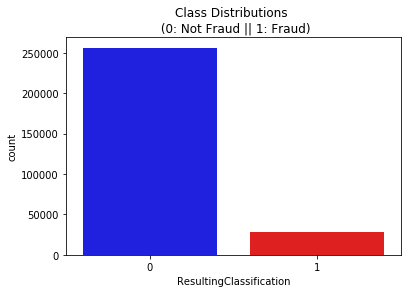

In [37]:
colours = ["blue","red"]
sns.countplot("ResultingClassification",data=df,palette=colours)
plt.title('Class Distributions \n (0: Not Fraud || 1: Fraud)')

In [38]:
print('No Frauds',round(df['ResultingClassification'].value_counts()[0]/len(df)*100,2),'% of the dataset')
print('Frauds',round(df['ResultingClassification'].value_counts()[1]/len(df)*100,2),'% of the dataset')

No Frauds 90.02 % of the dataset
Frauds 9.98 % of the dataset


In [40]:
y_anomaly_score = ccIF.decision_function(df_no_labels)
df['AnomalyScore'] = y_anomaly_score
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,ResultingClassification,AnomalyScore
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,0.159792
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,0.161604
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1,0.113580
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,0.147268
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,0.155863


In [41]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,ResultingClassification,AnomalyScore
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727,0.099808,0.161315
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527,0.299744,0.022855
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000,0.000000,-0.313886
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000,0.000000,0.156867
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000,0.000000,0.166719
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000,0.000000,0.172964
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000,1.000000,0.184103


In [50]:
is_flagged = (df['ResultingClassification'] == 1) | (df['Class'] == 1)
print(is_flagged.head())

0    False
1    False
2     True
3    False
4    False
dtype: bool


In [51]:
df_flagged = df[is_flagged]
print(df_flagged.shape)

(28479, 33)


In [52]:
df_flagged

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,ResultingClassification,AnomalyScore
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1,0.113580
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0,1,0.127180
14,12.0,-2.791855,-0.327771,1.641750,1.767473,-0.136588,0.807596,-0.422911,-1.907107,0.755713,...,1.020586,0.028317,-0.232746,-0.235557,-0.164778,-0.030154,58.80,0,1,0.143185
18,14.0,-5.401258,-5.450148,1.186305,1.736239,3.049106,-1.763406,-1.559738,0.160842,1.233090,...,2.458589,0.042119,-0.481631,-0.621272,0.392053,0.949594,46.80,0,1,0.127303
21,17.0,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,...,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,34.09,0,1,0.132268
23,18.0,0.247491,0.277666,1.185471,-0.092603,-1.314394,-0.150116,-0.946365,-1.617935,1.544071,...,-0.185353,0.423073,0.820591,-0.227632,0.336634,0.250475,22.75,0,1,0.140654
38,29.0,0.996370,-0.122589,0.546819,0.706580,0.134560,1.156995,-0.294561,0.407429,0.337863,...,0.162231,-0.575624,0.109795,0.373813,0.050552,0.005106,20.53,0,1,0.137498
40,32.0,1.249055,-0.624727,-0.710589,-0.991600,1.429973,3.692977,-1.090209,0.967291,0.850149,...,-0.129463,1.112970,0.500382,1.196549,-0.048220,0.005094,29.89,0,1,0.140144
48,35.0,1.386397,-0.794209,0.778224,-0.864708,-1.064132,0.351296,-1.191455,0.052686,-0.304404,...,-0.131025,-0.929668,0.181379,1.194928,0.000531,0.019911,30.90,0,1,0.133244
51,36.0,-1.004929,-0.985978,-0.038039,3.710061,-6.631951,5.122103,4.371691,-2.006868,-0.278736,...,0.969719,0.019445,0.570923,0.333278,0.857373,-0.075538,1402.95,0,1,0.100244


In [55]:
df.to_csv(path_or_buf = 'ccwithflaged.csv', index=False)

In [59]:
outliers = df.loc[df['ResultingClassification']==1]
outlier_index = list(outliers.index)

[[ 1.35982608  0.07305553]
 [-1.19188255 -0.26619423]
 [ 1.35831315  1.34027951]
 ...
 [-1.91956996  0.30139937]
 [ 0.24047089 -0.53032232]
 [ 0.53337212  0.18967135]]
                0          1
0        1.359826   0.073056
1       -1.191883  -0.266194
2        1.358313   1.340280
3        0.966184   0.185001
4        1.158119  -0.877987
5        0.425969  -0.960434
6       -1.229671  -0.140914
7        0.644192  -1.418165
8        0.894254  -0.286218
9        0.338200  -1.119827
10      -1.448977   1.176555
11      -0.384950  -0.616068
12      -1.250014   1.221594
13      -1.069422  -0.287750
14       2.791806   0.327730
15       0.752424  -0.345518
16      -1.103304   0.040163
17       0.436873  -0.919108
18       5.401225   5.450182
19      -1.492877   1.029513
20      -0.695006   1.361678
21      -0.962413  -0.328107
22      -1.166481  -0.501694
23      -0.247534  -0.277605
24       1.946561   0.044978
25       2.074271   0.121555
26      -1.173343  -0.353756
27      -1.322728   

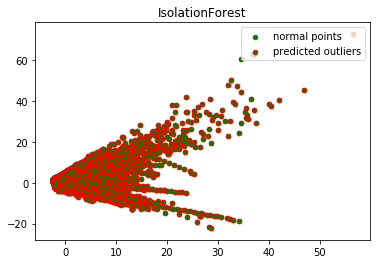

In [81]:
test_df = df.drop(["Time","Amount","Class","ResultingClassification","AnomalyScore"],axis=1)
X_reduced = pca.fit_transform(test_df)
print(X_reduced)
res = pd.DataFrame(X_reduced)
#print(res)
Z = np.array(res)
#print(Z)
plt.title("IsolationForest")
#plt.contourf(Z,cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

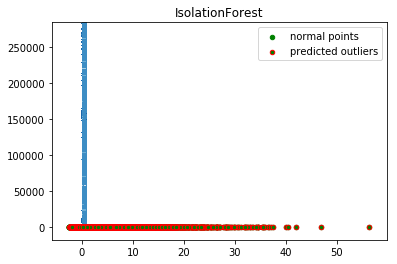

In [73]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(df.drop(["Time","Amount","Class","ResultingClassification","AnomalyScore"],axis=1))
res=pd.DataFrame(pca.transform(df.drop(["Time","Amount","Class","ResultingClassification","AnomalyScore"],axis=1)))
Z = np.array(res)
plt.title("IsolationForest")
plt.contourf(Z)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [66]:
pca = PCA(2) #reduce to k = 2 dimensions
X = df.drop(["Time","Amount","Class","ResultingClassification","AnomalyScore"],axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_reduce = pca.fit_transfrom(X)
res = pd.DataFrame(pca.transform(X_reduce))
Z = np.array(res)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()


AttributeError: 'PCA' object has no attribute 'fit_transfrom'